In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [14]:
user_info = pd.read_csv('./user_info.csv')
user_info['reg_date'] = pd.to_datetime(user_info['reg_date']).dt.date
source_1 = pd.read_csv('./source_1.csv')
source_2 = pd.read_csv('./source_2.csv')
role_info_3d = pd.read_pickle('./role_info_3d.pkl')

In [15]:
source_1.rename(columns={'chl_user_id':'channel_id'},inplace=True)
source_1.drop_duplicates(subset=['channel_id','source_id'],inplace=True)
source = pd.merge(source_1,source_2,on=['channel_id','source_id'],how='left',validate='one_to_many')
source.dropna(inplace=True)
source['create_time'] = pd.to_datetime(source['create_time']).dt.date
source['tdate'] = pd.to_datetime(source['tdate']).dt.date
source.rename(columns={'tdate':'reg_date'},inplace=True)

In [19]:
user_info = user_info[['user_id','channel_id','source_id','reg_date']]
user_info.drop_duplicates(inplace=True)

In [20]:
source.drop_duplicates(subset=['channel_id','source_id','reg_date'],inplace=True)
source_info = pd.merge(source,user_info,on=['channel_id','source_id','reg_date'],how='left',validate='one_to_many')
source_info.dropna(inplace=True)

In [22]:
source_info['user_id'] = source_info['user_id'].astype(np.int64)
role_info_3d['user_id'] = role_info_3d['user_id'].astype(np.int64)
data = pd.merge(source_info,role_info_3d,on='user_id',how='left',validate='one_to_many')
data.dropna(inplace=True)

In [26]:
pd.set_option('display.max_columns',None)

In [24]:
data_amount_y = data[data['amount']!=0]

In [25]:
data_amount_y.shape

(3628022, 34)

In [58]:
data_amount_y.head()

,channel_id,source_id,create_time,reg_date,amount,paper_use_amount,click_num,down_num,pv,create_role_num,user_id,cp_server_no,cp_role_id,role_created_login_num,role_created_active,role_created_online,max_role_level,ip_num,pay_num,pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_rate,pay_avg,role_created_30_pay_sum,cpc,source_pay_sum,b_r,m_r,s_r,rubbish,common
0,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100261967,660192,13814061,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,1,0
1,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100262535,660191,13814172,40.0,3.0,50265.0,57.0,2.0,0.0,0.0,68.0,33.0,7.0,27.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,0,1
2,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100262535,660192,13814172,27.0,3.0,46271.0,57.0,2.0,0.0,0.0,35.0,16.0,0.0,27.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,0,1
3,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100262535,660193,13814172,19.0,3.0,25424.0,54.0,2.0,0.0,0.0,14.0,12.0,18.0,15.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,0,1
4,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100268013,660192,13815011,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,1,0


In [28]:
# 统计cpc(计划创角成本)
data_amount_y['cpc'] = data_amount_y['amount']/(data_amount_y['create_role_num']+1e-4)

In [29]:
# 统计每条计划的30天回款source_pay_sum
group_1 = data_amount_y.groupby(['channel_id','source_id','reg_date'])
temp = group_1['role_created_30_pay_sum'].agg([('source_pay_sum', 'sum')]).reset_index()
data_amount_y = pd.merge(data_amount_y,temp,on=['channel_id','source_id','reg_date'],how='left',validate='many_to_one')

In [35]:
data_amount_y['b_r'] = (data_amount_y['role_created_30_pay_sum']>=2000).astype(int)
data_amount_y['m_r'] = ((data_amount_y['role_created_30_pay_sum']<2000) & (data_amount_y['role_created_30_pay_sum']>=100)).astype(int)
data_amount_y['s_r'] = ((data_amount_y['role_created_30_pay_sum']<100) & (data_amount_y['role_created_30_pay_sum']>0)).astype(int)

In [53]:
data_amount_y['rubbish'] = ((data_amount_y['role_created_online']<=600) & (data_amount_y['role_created_login_num']<=2)&
                            (data_amount_y['max_role_level']<=5)&(data_amount_y['role_created_30_pay_sum']==0)).astype(int)
data_amount_y['common'] = (~((data_amount_y['role_created_online']<=600) & (data_amount_y['role_created_login_num']<=2)&
                (data_amount_y['max_role_level']<=5)) &(data_amount_y['role_created_30_pay_sum']==0)).astype(int)

In [108]:
data_amount_y.to_pickle('./data_amount_y.pkl')

In [54]:
print(data_amount_y['b_r'].sum())
print(data_amount_y['m_r'].sum())
print(data_amount_y['s_r'].sum())
print(data_amount_y['rubbish'].sum())
print(data_amount_y['common'].sum())

4773
30330
36002
2023913
1533004


In [59]:
print(data_amount_y['b_r'].sum()/data_amount_y.shape[0])
print(data_amount_y['m_r'].sum()/data_amount_y.shape[0])
print(data_amount_y['s_r'].sum()/data_amount_y.shape[0])
print(data_amount_y['rubbish'].sum()/data_amount_y.shape[0])
print(data_amount_y['common'].sum()/data_amount_y.shape[0])

0.0013155929043429174
0.008359927255126898
0.009923313585198767
0.5578557682395531
0.4225453980157783


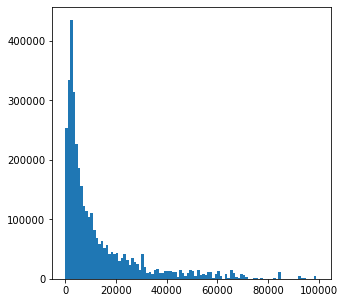

In [61]:
plt.figure(figsize=(5,5))
plt.hist(data_amount_y['amount'],bins=100,range=(0,100000))
plt.show()

In [63]:
source_grade_1 = data_amount_y[data_amount_y['amount']>=30000]
source_grade_2 = data_amount_y[(data_amount_y['amount']<30000)&(data_amount_y['amount']>=10000)]
source_grade_3 = data_amount_y[(data_amount_y['amount']<10000)&(data_amount_y['amount']>=2000)]
source_grade_4 = data_amount_y[(data_amount_y['amount']<2000)&(data_amount_y['amount']>=500)]
source_grade_5 = data_amount_y[data_amount_y['amount']<500]

In [68]:
# source_grade_1的用户质量分布
b_r = source_grade_1['b_r'].sum()/source_grade_1.shape[0]
m_r = source_grade_1['m_r'].sum()/source_grade_1.shape[0]
s_r = source_grade_1['s_r'].sum()/source_grade_1.shape[0]
rubbish = source_grade_1['rubbish'].sum()/source_grade_1.shape[0]
common = source_grade_1['common'].sum()/source_grade_1.shape[0]
print(source_grade_1['b_r'].sum()/source_grade_1.shape[0])
print(source_grade_1['m_r'].sum()/source_grade_1.shape[0])
print(source_grade_1['s_r'].sum()/source_grade_1.shape[0])
print(source_grade_1['rubbish'].sum()/source_grade_1.shape[0])
print(source_grade_1['common'].sum()/source_grade_1.shape[0])

0.0017201065498226003
0.010083079826581584
0.01131486968323204
0.5333980023008075
0.4434839416395563


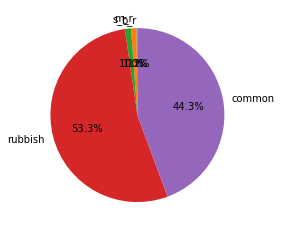

In [90]:
label_list = ['b_r','m_r','s_r','rubbish','common']
size = [b_r,m_r,s_r,rubbish,common]
plt.pie(size,labels=label_list,autopct="%1.1f%%",startangle=90,pctdistance=0.6)
plt.show()

0.0015277103400904999
0.00920286679851557
0.010667057117418374
0.5384602962186208
0.44014206952535473


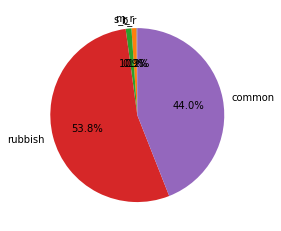

In [74]:
# source_grade_2的用户质量分布
b_r_2 = source_grade_2['b_r'].sum()/source_grade_2.shape[0]
m_r_2 = source_grade_2['m_r'].sum()/source_grade_2.shape[0]
s_r_2 = source_grade_2['s_r'].sum()/source_grade_2.shape[0]
rubbish_2 = source_grade_2['rubbish'].sum()/source_grade_2.shape[0]
common_2 = source_grade_2['common'].sum()/source_grade_2.shape[0]
print(b_r_2)
print(m_r_2)
print(s_r_2)
print(rubbish_2)
print(common_2)
label_list = ['b_r','m_r','s_r','rubbish','common']
size = [b_r_2, m_r_2, s_r_2, rubbish_2, common_2]
plt.pie(size,labels=label_list,autopct="%1.1f%%",startangle=90,pctdistance=0.6)
plt.show()

0.0012066204852786268
0.008135035311748503
0.00975371669274978
0.5768369891923003
0.4040676383179228


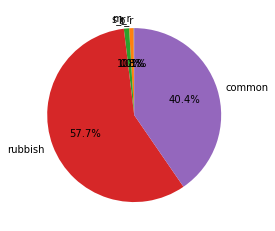

In [75]:
# source_grade_3的用户质量分布
b_r_3 = source_grade_3['b_r'].sum()/source_grade_3.shape[0]
m_r_3 = source_grade_3['m_r'].sum()/source_grade_3.shape[0]
s_r_3 = source_grade_3['s_r'].sum()/source_grade_3.shape[0]
rubbish_3 = source_grade_3['rubbish'].sum()/source_grade_3.shape[0]
common_3 = source_grade_3['common'].sum()/source_grade_3.shape[0]
print(b_r_3)
print(m_r_3)
print(s_r_3)
print(rubbish_3)
print(common_3)
label_list = ['b_r','m_r','s_r','rubbish','common']
size = [b_r_3, m_r_3, s_r_3, rubbish_3, common_3]
plt.pie(size,labels=label_list,autopct="%1.1f%%",startangle=90,pctdistance=0.6)
plt.show()

0.0009479708272281951
0.006223634561367716
0.008090724929778031
0.561037986839692
0.4236996828419341


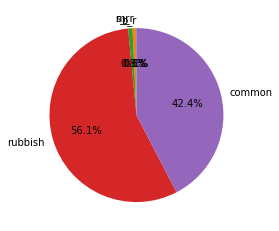

In [76]:
# source_grade_4的用户质量分布
b_r_4 = source_grade_4['b_r'].sum()/source_grade_4.shape[0]
m_r_4 = source_grade_4['m_r'].sum()/source_grade_4.shape[0]
s_r_4 = source_grade_4['s_r'].sum()/source_grade_4.shape[0]
rubbish_4 = source_grade_4['rubbish'].sum()/source_grade_4.shape[0]
common_4 = source_grade_4['common'].sum()/source_grade_4.shape[0]
print(b_r_4)
print(m_r_4)
print(s_r_4)
print(rubbish_4)
print(common_4)
label_list = ['b_r','m_r','s_r','rubbish','common']
size = [b_r_4, m_r_4, s_r_4, rubbish_4, common_4]
plt.pie(size,labels=label_list,autopct="%1.1f%%",startangle=90,pctdistance=0.6)
plt.show()

0.0011003153582410674
0.006818025523386614
0.008419377339398166
0.5198204128147442
0.4638418689642299


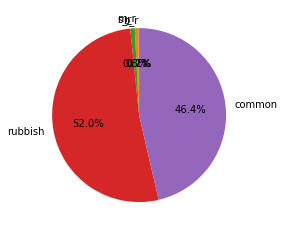

In [77]:
# source_grade_5的用户质量分布
b_r_5 = source_grade_5['b_r'].sum()/source_grade_5.shape[0]
m_r_5 = source_grade_5['m_r'].sum()/source_grade_5.shape[0]
s_r_5 = source_grade_5['s_r'].sum()/source_grade_5.shape[0]
rubbish_5 = source_grade_5['rubbish'].sum()/source_grade_5.shape[0]
common_5 = source_grade_5['common'].sum()/source_grade_5.shape[0]
print(b_r_5)
print(m_r_5)
print(s_r_5)
print(rubbish_5)
print(common_5)
label_list = ['b_r','m_r','s_r','rubbish','common']
size = [b_r_5, m_r_5, s_r_5, rubbish_5, common_5]
plt.pie(size,labels=label_list,autopct="%1.1f%%",startangle=90,pctdistance=0.6)
plt.show()

In [65]:
print(source_grade_1.shape[0]/data_amount_y.shape[0])
print(source_grade_2.shape[0]/data_amount_y.shape[0])
print(source_grade_3.shape[0]/data_amount_y.shape[0])
print(source_grade_4.shape[0]/data_amount_y.shape[0])
print(source_grade_5.shape[0]/data_amount_y.shape[0])

0.1253087770691578
0.25601856879588936
0.45686657908910144
0.1337497402165698
0.02805633482928163


In [78]:
data_amount_y.head()

,channel_id,source_id,create_time,reg_date,amount,paper_use_amount,click_num,down_num,pv,create_role_num,user_id,cp_server_no,cp_role_id,role_created_login_num,role_created_active,role_created_online,max_role_level,ip_num,pay_num,pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_rate,pay_avg,role_created_30_pay_sum,cpc,source_pay_sum,b_r,m_r,s_r,rubbish,common
0,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100261967,660192,13814061,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,1,0
1,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100262535,660191,13814172,40.0,3.0,50265.0,57.0,2.0,0.0,0.0,68.0,33.0,7.0,27.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,0,1
2,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100262535,660192,13814172,27.0,3.0,46271.0,57.0,2.0,0.0,0.0,35.0,16.0,0.0,27.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,0,1
3,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100262535,660193,13814172,19.0,3.0,25424.0,54.0,2.0,0.0,0.0,14.0,12.0,18.0,15.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,0,1
4,20953,252731,2020-01-02,2020-01-02,1562.56,1562.56,1552.0,55.0,53605.0,51.0,100268013,660192,13815011,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.638371,0.0,0,0,0,1,0


In [80]:
soure_amout_y = data_amount_y[['channel_id','source_id','create_time','reg_date','amount','paper_use_amount','click_num','down_num',
              'create_role_num','cpc','source_pay_sum']]

In [81]:
soure_amout_y.drop_duplicates(['channel_id','source_id','reg_date'],inplace=True)

In [82]:
soure_amout_y.shape

(39764, 11)

In [83]:
source_grade_1_1 = soure_amout_y[soure_amout_y['amount']>=30000]
source_grade_1_2 = soure_amout_y[(soure_amout_y['amount']<30000)&(soure_amout_y['amount']>=10000)]
source_grade_1_3 = soure_amout_y[(soure_amout_y['amount']<10000)&(soure_amout_y['amount']>=2000)]
source_grade_1_4 = soure_amout_y[(soure_amout_y['amount']<2000)&(soure_amout_y['amount']>=500)]
source_grade_1_5 = soure_amout_y[soure_amout_y['amount']<500]

In [84]:
print(source_grade_1_1.shape[0]/soure_amout_y.shape[0])
print(source_grade_1_2.shape[0]/soure_amout_y.shape[0])
print(source_grade_1_3.shape[0]/soure_amout_y.shape[0])
print(source_grade_1_4.shape[0]/soure_amout_y.shape[0])
print(source_grade_1_5.shape[0]/soure_amout_y.shape[0])

0.009028266773966401
0.04680112664721859
0.28226536565737853
0.3268534352680817
0.3350518056533548


In [85]:
print('source_grade_1平均cpc:',round(source_grade_1_1[source_grade_1_1['create_role_num']!=0]['cpc'].mean(),2))
print('source_grade_2平均cpc:',round(source_grade_1_2[source_grade_1_2['create_role_num']!=0]['cpc'].mean(),2))
print('source_grade_3平均cpc:',round(source_grade_1_3[source_grade_1_3['create_role_num']!=0]['cpc'].mean(),2))
print('source_grade_4平均cpc:',round(source_grade_1_4[source_grade_1_4['create_role_num']!=0]['cpc'].mean(),2))
print('source_grade_5平均cpc:',round(source_grade_1_5[source_grade_1_5['create_role_num']!=0]['cpc'].mean(),2))

source_grade_1平均cpc: 92.59
source_grade_2平均cpc: 102.43
source_grade_3平均cpc: 50.23
source_grade_4平均cpc: 71.86
source_grade_5平均cpc: 64.34


In [86]:
print('source_grade_1平均30日ROI',round(source_grade_1_1['source_pay_sum'].sum()/source_grade_1_1['amount'].sum(),2))
print('source_grade_2平均30日ROI',round(source_grade_1_2['source_pay_sum'].sum()/source_grade_1_2['amount'].sum(),2))
print('source_grade_3平均30日ROI',round(source_grade_1_3['source_pay_sum'].sum()/source_grade_1_3['amount'].sum(),2))
print('source_grade_4平均30日ROI',round(source_grade_1_4['source_pay_sum'].sum()/source_grade_1_4['amount'].sum(),2))
print('source_grade_5平均30日ROI',round(source_grade_1_5['source_pay_sum'].sum()/source_grade_1_5['amount'].sum(),2))

source_grade_1平均30日ROI 0.53
source_grade_2平均30日ROI 0.59
source_grade_3平均30日ROI 0.53
source_grade_4平均30日ROI 0.42
source_grade_5平均30日ROI 0.51
